In [1]:
# from ADlasso2 import AD2_w_utils as ad
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import time
import scipy
import sklearn
import copy
import importlib
import scanpy as sc


In [2]:
# read in data with complete cells
adata = sc.read('/home/evanlee/PBMC_Hao/Hao_PBMC.h5ad')
print(adata.shape)  # row is cells, column is gene
# (161764, 20568)

sc.pp.log1p(adata)

(161764, 20568)


In [3]:
label = adata.obs['celltype.l1'].tolist()

In [4]:
types = np.unique(adata.obs['celltype.l1']).tolist()

In [5]:
types

['B', 'CD4 T', 'CD8 T', 'DC', 'Mono', 'NK', 'other', 'other T']

In [6]:
# Delete the 'neighbors' key from adata.uns
# if 'neighbors' already exists in adata.uns, error would occurs at sc.pp.neighbors
if 'neighbors' in adata.uns:
    del adata.uns['neighbors']

## Read in the ADlasso features from 7 cell types

In [7]:
!pwd

/home/evanlee/PBMC_Hao/Level_1_alpha0.01


In [8]:
all_features = {}
# positive_features = {}
for celltype in types:
    print('Reading:', celltype)
    # all features (including positive and negative)
    features_df = pd.read_csv(f'./Level1_result/{celltype}/{celltype}_features.txt', sep='\t', header=None, names=['Gene', 'Weight', 'Tendency'])
    all_features[celltype] = features_df['Gene'].tolist()
    # positive features
#     positive_features_df = features_df[features_df['Tendency'] == 1]
#     positive_features[celltype] = positive_features_df['Gene'].tolist()


Reading: B
Reading: CD4 T
Reading: CD8 T
Reading: DC
Reading: Mono
Reading: NK
Reading: other
Reading: other T


In [9]:
for celltype in all_features.keys():
    print(celltype, len(all_features[celltype]))

B 17
CD4 T 1786
CD8 T 26
DC 1
Mono 22
NK 27
other 1
other T 2


## B cells vs. Rest

In [11]:
celltype = 'B'

celltype_features = all_features[celltype]

# Leiden UMAP with celltype features
adata_type_features = adata[:, celltype_features]
adata_type_features.shape

(161764, 17)

In [21]:
# list the features of B cells
adata_type_features.var_names

Index(['ENSG00000142669', 'ENSG00000116191', 'ENSG00000081237',
       'ENSG00000211592', 'ENSG00000153064', 'ENSG00000081189',
       'ENSG00000075624', 'ENSG00000205542', 'ENSG00000156738',
       'ENSG00000167996', 'ENSG00000251562', 'ENSG00000136156',
       'ENSG00000211899', 'ENSG00000007312', 'ENSG00000101608',
       'ENSG00000105369', 'ENSG00000211677'],
      dtype='object', name='gene_ids')

In [12]:
# PCA
sc.tl.pca(adata_type_features, svd_solver='arpack')

# neighborhood graph
sc.pp.neighbors(adata_type_features, n_neighbors=15)

/home/evanlee/.local/lib/python3.8/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/evanlee/.local/lib/python3.8/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/evanlee/.local/lib/python3.8/site-packages/umap/distances.py:1086: NumbaDeprecationWarning: Th

In [13]:
# UMAP
sc.tl.umap(adata_type_features)

/home/evanlee/.local/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


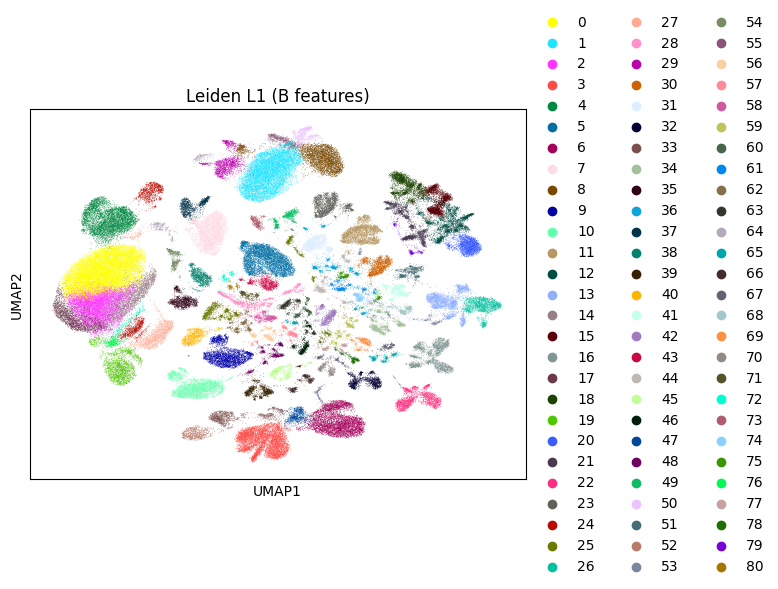

In [14]:
sc.tl.leiden(adata_type_features)
# Plot Leiden UMAP
sc.pl.umap(adata_type_features, color='leiden', title='Leiden L1 (B features)')

## Plot Leiden UMAP with HVGn (celltype B, n=17)

In [15]:
adata.obs.columns

Index(['nCount_ADT', 'nFeature_ADT', 'nCount_RNA', 'nFeature_RNA',
       'orig.ident', 'lane', 'donor_id', 'time', 'celltype.l1', 'celltype.l2',
       'celltype.l3', 'Phase', 'nCount_SCT', 'nFeature_SCT',
       'cell_type_ontology_term_id', 'sex_ontology_term_id',
       'self_reported_ethnicity_ontology_term_id',
       'development_stage_ontology_term_id', 'disease_ontology_term_id',
       'assay_ontology_term_id', 'is_primary_data',
       'organism_ontology_term_id', 'tissue_ontology_term_id',
       'suspension_type', 'cell_type', 'assay', 'disease', 'organism', 'sex',
       'tissue', 'self_reported_ethnicity', 'development_stage'],
      dtype='object')

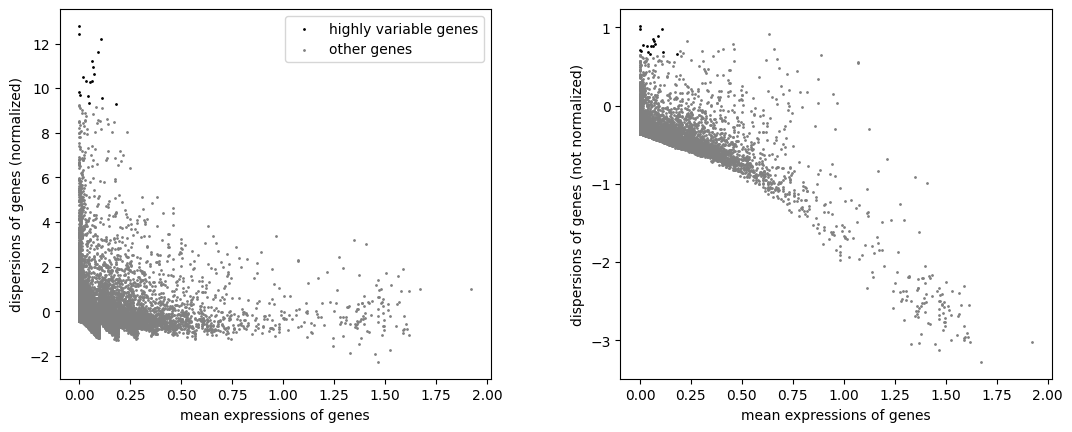

In [17]:
n = len(celltype_features)  # 17
# select HVG2000 (from original 27998 genes)
sc.pp.highly_variable_genes(adata, n_top_genes=n)
sc.pl.highly_variable_genes(adata)

In [18]:
sum(adata.var['highly_variable'])

17

In [19]:
# filtering the non-Highly variable genes in data
adata_HVGn = adata[:, adata.var.highly_variable]  # choose columns, Genes
adata_HVGn.shape

(161764, 17)

In [20]:
# list the HVGs
adata_HVGn.var_names

Index(['ENSG00000173369', 'ENSG00000179639', 'ENSG00000168497',
       'ENSG00000115009', 'ENSG00000169704', 'ENSG00000163737',
       'ENSG00000163736', 'ENSG00000163734', 'ENSG00000127920',
       'ENSG00000107317', 'ENSG00000156738', 'ENSG00000169877',
       'ENSG00000101162', 'ENSG00000211679', 'ENSG00000211685',
       'ENSG00000196415', 'ENSG00000239855'],
      dtype='object', name='gene_ids')

In [22]:
# PCA
sc.tl.pca(adata_HVGn, svd_solver='arpack')

# neighborhood graph
sc.pp.neighbors(adata_HVGn, n_neighbors=15)

In [23]:
# UMAP
sc.tl.umap(adata_HVGn)

/home/evanlee/.local/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


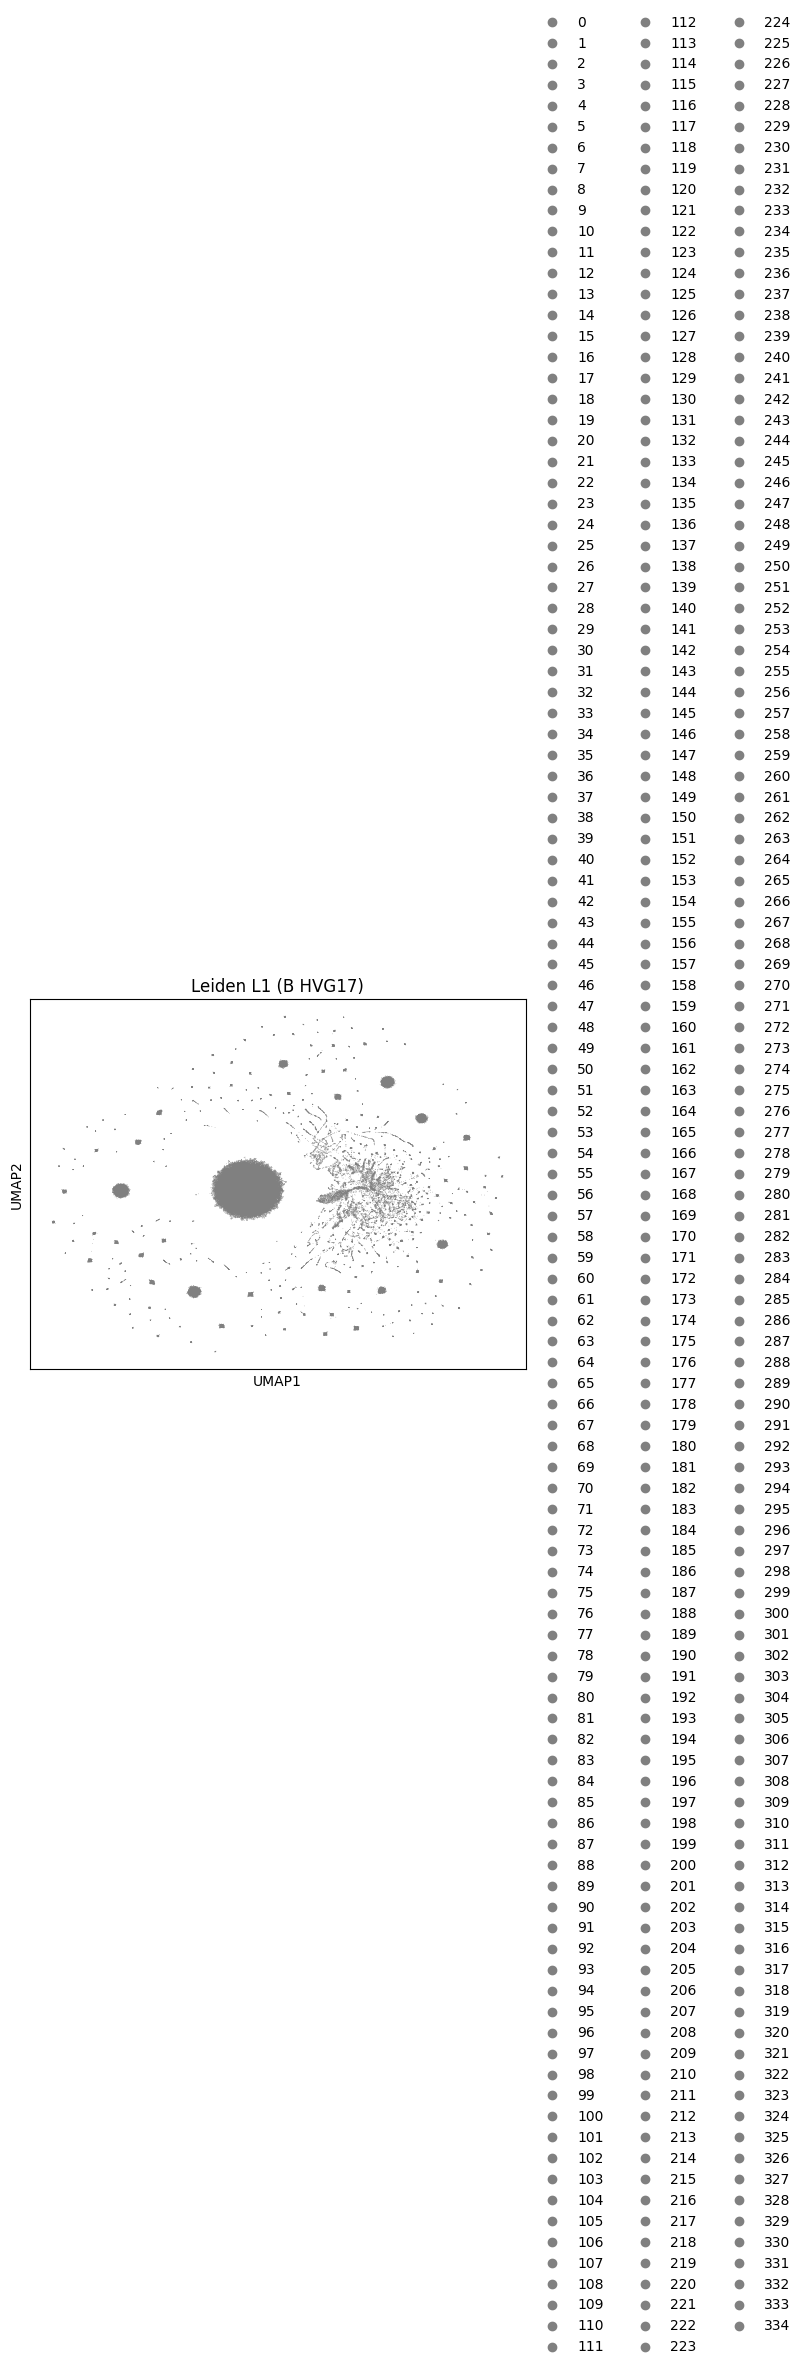

In [24]:
sc.tl.leiden(adata_HVGn)
# Plot Leiden UMAP
sc.pl.umap(adata_HVGn, color='leiden', title=f'Leiden L1 (B HVG{n})')

In [28]:
# count how many Leiden clusters
HVGn_leiden = np.unique(adata_HVGn.obs['leiden'])
len(HVGn_leiden)

335

In [26]:
# compare ADlasso B cells features and HVGs
b = adata_type_features.var_names
h = adata_HVGn.var_names
inter = b.intersection(h)

In [27]:
inter

Index(['ENSG00000156738'], dtype='object', name='gene_ids')

## ARI and NMI

In [29]:
types

['B', 'CD4 T', 'CD8 T', 'DC', 'Mono', 'NK', 'other', 'other T']

In [31]:
np.unique(adata.obs['celltype.l1'])

array(['B', 'CD4 T', 'CD8 T', 'DC', 'Mono', 'NK', 'other', 'other T'],
      dtype=object)

In [35]:
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.metrics import normalized_mutual_info_score

HVG_performance = pd.DataFrame(columns=['ARI', 'NMI'])
all_features_performance = pd.DataFrame(columns=['ARI', 'NMI'])
positive_features_performance = pd.DataFrame(columns=['ARI', 'NMI'])

for celltype in types:
    # HVG17
    hvg_true = [1 if x == celltype else 0 for x in label]
    hvg_pred = adata_HVGn.obs['leiden'].tolist()
    ari = adjusted_rand_score(hvg_true, hvg_pred)
    nmi = normalized_mutual_info_score(hvg_true, hvg_pred)
    new_row = pd.DataFrame({'ARI': ari, 'NMI': nmi}, index=[celltype])
    HVG_performance = pd.concat([HVG_performance, new_row])

    # 17 ADlasso features
    all_features_true = [1 if x == celltype else 0 for x in label]
    all_features_pred = adata_type_features.obs['leiden'].tolist()
    ari = adjusted_rand_score(all_features_true, all_features_pred)
    nmi = normalized_mutual_info_score(all_features_true, all_features_pred)
    new_row = pd.DataFrame({'ARI': ari, 'NMI': nmi}, index=[celltype])
    all_features_performance = pd.concat([all_features_performance, new_row])
    

In [36]:
HVG_performance

,ARI,NMI
B,0.003388,0.098297
CD4 T,-0.000119,0.021206
CD8 T,-0.000353,0.011169
DC,0.000621,0.026534
Mono,0.000813,0.031364
NK,0.000123,0.014540
other,0.000378,0.023326
other T,-0.000125,0.002986


In [37]:
all_features_performance

,ARI,NMI
B,0.010514,0.135005
CD4 T,0.003211,0.066902
CD8 T,-0.001701,0.036880
DC,0.001063,0.020380
Mono,0.033640,0.168866
NK,-0.002987,0.030512
other,0.001692,0.022647
other T,-0.001520,0.009877


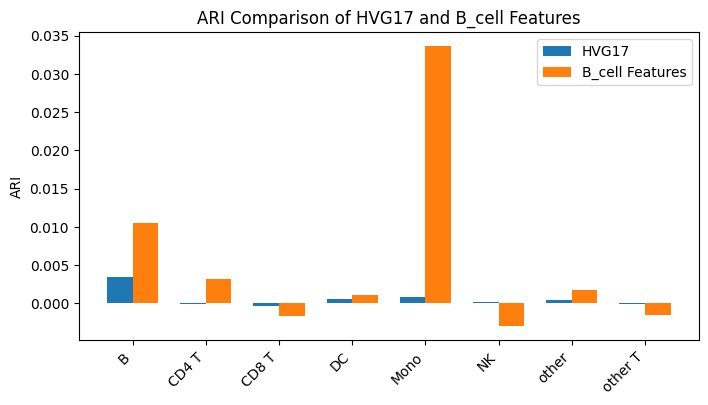

In [40]:
# Plot ARI comparison of HVG17 and B cell features

# assume HVG_performance and all_features_performance are pandas DataFrames
HVG_ari = HVG_performance['ARI'].tolist()
all_features_ari = all_features_performance['ARI'].tolist()

# set up the figure and axis
fig, ax = plt.subplots(figsize=(8, 4))

# set up the x-axis labels and positions
labels = HVG_performance.index.tolist()
x = np.arange(len(labels))

# set up the bar widths and positions
width = 0.35
offset = width / 2

# plot the bars
rects1 = ax.bar(x - offset, HVG_ari, width, label='HVG17')
rects2 = ax.bar(x + offset, all_features_ari, width, label='B_cell Features')

# add labels and legend
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=45, ha='right')
ax.set_ylabel('ARI')
ax.set_title('ARI Comparison of HVG17 and B_cell Features')
ax.legend()

# show the plot
plt.show()

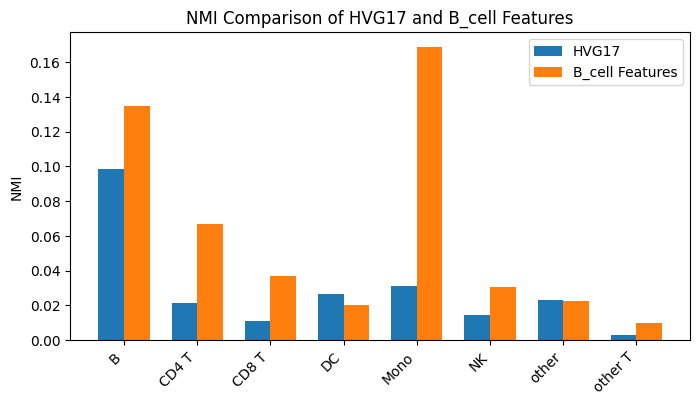

In [41]:
# Plot NMI comparison of HVG and all features
HVG_nmi = HVG_performance['NMI'].tolist()
all_features_nmi = all_features_performance['NMI'].tolist()

# set up the figure and axis
fig, ax = plt.subplots(figsize=(8, 4))
labels = HVG_performance.index.tolist()
x = np.arange(len(labels))

width = 0.35
offset = width / 2

rects1 = ax.bar(x - offset, HVG_nmi, width, label='HVG17')
rects2 = ax.bar(x + offset, all_features_nmi, width, label='B_cell Features')

ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=45, ha='right')
ax.set_ylabel('NMI')
ax.set_title('NMI Comparison of HVG17 and B_cell Features')
ax.legend()
plt.show()